###  Convolutional neural network
Use  Kaggle cats-vs-dogs dataset to train a CNN. We use a smaller dataset of 2,000 training images, 1,000 validation images, and 1,000 test images, instead of all the data to train it fast. This is a balanced-binary classification problem, so classification accuracy is an appropriate measure of success.

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras import models,layers,optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as tf

Gain access to google drive to read data and save trained models.

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


### Data preprocessing 

Currently, the data sits on a drive as JPEG files, so the steps for getting it into the network are roughly as follows:
 
1.   Read the picture files.
2.   Decode the JPEG content to RGB grids of pixels.
3.    Convert these into floating-point tensors.
4.    Rescale the pixel values (between 0 and 255) to the [0, 1] interval (as you know,
neural networks prefer to deal with small input values).

Keras has a module with image-processing helper tools, located at keras.preprocessing.image. In particular, it contains the class ImageDataGenerator, which lets you quickly set up Python generators that can automatically turn image files on disk into batches of preprocessed tensors.

In [0]:
dir = '/content/gdrive/My Drive/Colab Notebooks/data/dogs-vs-cats_small'

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(dir+'/train', 
                                                    target_size=(150,150), 
                                                    batch_size=20,
                                                    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(dir+'/validation',
                                                        target_size=(150,150), 
                                                        batch_size=20,
                                                        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Let’s look at the output of one of these generators: it yields batches of 150 × 150 RGB images (shape (20, 150, 150, 3)) and binary labels (shape (20,))

In [0]:
for data_batch, labels_batch in train_generator:
  print('data batch shape:', data_batch.shape)
  print('labels batch shape:', labels_batch.shape)
  break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


Instantiating a small convnet for dogs vs. cats classification. Because you’re attacking a binary classification problem, you’ll end the network with a single unit (a Dense layer of size 1) and a sigmoid activation. This unit will encode the probability that the network is looking at one class or the other.

In [0]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape=(150,150,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)       147584    
__________

Let’s fit the model to the data using the generator. You do so using the fit_generator method, the equivalent of fit for data generators like this one. It expects as its first argument a Python generator that will yield batches of inputs and targets indefinitely, like this one does. Because the data is being generated endlessly, the Keras model needs to know how many samples to draw from the generator before declaring an epoch over. This is the role of the steps_per_epoch argument: after having drawn steps_per_epoch batches from the generator—that is, after having run for steps_per_epoch gradient descent steps—the fitting process will go to the next epoch. In this case, batches are 20 samples, so it will take 100 batches until you see your target of 2,000 samples.

The validation_steps argument, which tells the process how many batches to draw from the validation generator for evaluation.

In [0]:
model.compile(optimizer=optimizers.RMSprop(lr=1e-4), loss='binary_crossentropy', metrics = ['accuracy'])
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=30, validation_data= validation_generator, validation_steps=50)

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
100/100 [==============================] - 698s 7s/step - loss: 0.6931 - acc: 0.5120 - val_loss: 0.6990 - val_acc: 0.5000
Epoch 2/30
100/100 [==============================] - 14s 142ms/step - loss: 0.6788 - acc: 0.5640 - val_loss: 0.6705 - val_acc: 0.5630
Epoch 3/30
100/100 [==============================] - 14s 143ms/step - loss: 0.6463 - acc: 0.6370 - val_loss: 0.6470 - val_acc: 0.6260
Epoch 4/30
100/100 [==============================] - 16s 156ms/step - loss: 0.6035 - acc: 0.6820 - val_loss: 0.6210 - val_acc: 0.6500
Epoch 5/30
100/100 [==============================] - 16s 157ms/step - loss: 0.5765 - acc: 0.6970 - val_loss: 0.6090 - val_acc: 0.6540
Epoch 6/30
100/100 [==============================] - 15s 148ms/step - loss: 0.5582 - acc: 0.7100 - val_loss: 0.6118 - val_acc: 0.6580
Epoch 7/30
100/100 [==============================] - 16s 161ms/step - loss: 0.5358 - acc: 0.7280 - val_loss: 0.5869 - val_acc: 0.6860
Epoch 8/3

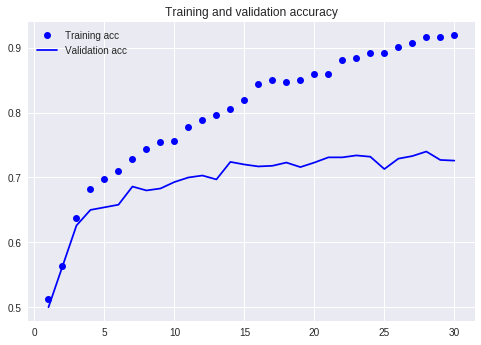

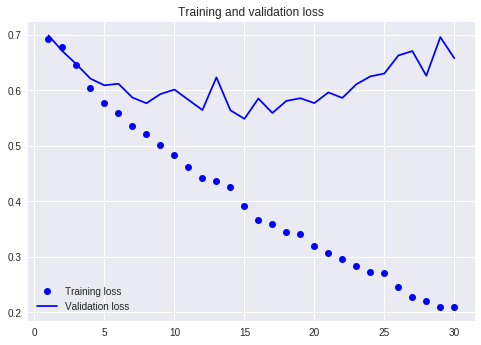

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)

plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

model.save('./gdrive/My Drive/Colab Notebooks/models/cats_and_dogs_small_1.h5')

These plots are characteristic of overfitting. The training accuracy increases linearly over time, until it reaches nearly 100%, whereas the validation accuracy stalls at 70–72%.

Load model

In [0]:
model = models.load_model('./gdrive/My Drive/Colab Notebooks/models/cats_and_dogs_small_1.h5')
#model.summary()

### Data Augmentation

Perform Data augmentation on training data to increase training set size

In [0]:
train_datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range=40,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest')

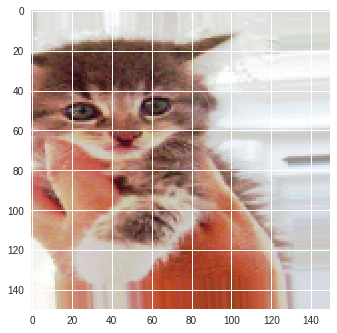

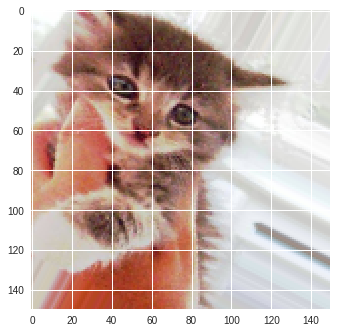

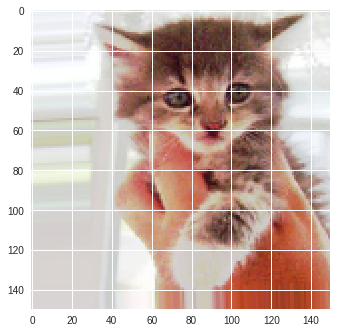

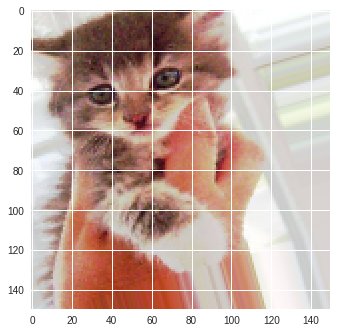

In [0]:
fnames = [os.path.join(dir+'/train/cats',fname) for fname in os.listdir(dir+'/train/cats')]

img = image.load_img(fnames[3], target_size=(150,150))

x = image.img_to_array(img) #convert to numpy array with shape (150,150,3)
x = x.reshape((1,)+x.shape)  #reshape it to (1,150,150,3)


i=0
for batch in train_datagen.flow(x,batch_size=1):
  plt.figure(i)
  imgplot = plt.imshow(image.array_to_img(batch[0]))
  i += 1
  if i%4 == 0:
    break
    
plt.show()

Train a new CNN using data augmented training set and also adding Dropout regularization

In [0]:
model = models.Sequential()
model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer=optimizers.RMSprop(lr=1e-4),metrics=['accuracy'])

In [0]:
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(dir+'/train',target_size=(150,150),batch_size=32,class_mode='binary')

validation_generator = test_datagen.flow_from_directory(dir+'/validation',target_size=(150,150),batch_size=32,class_mode='binary')

history = model.fit_generator(train_generator,
                             steps_per_epoch=100,
                             epochs=100,
                             validation_data=validation_generator,
                             validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 422s 4s/step - loss: 0.6949 - acc: 0.5069 - val_loss: 0.6797 - val_acc: 0.5742
Epoch 2/100
100/100 [==============================] - 35s 354ms/step - loss: 0.6836 - acc: 0.5534 - val_loss: 0.6691 - val_acc: 0.5657
Epoch 3/100
100/100 [==============================] - 35s 354ms/step - loss: 0.6714 - acc: 0.5859 - val_loss: 0.6383 - val_acc: 0.6364
Epoch 4/100
100/100 [==============================] - 34s 344ms/step - loss: 0.6538 - acc: 0.6144 - val_loss: 0.6615 - val_acc: 0.5857
Epoch 5/100
100/100 [==============================] - 35s 345ms/step - loss: 0.6371 - acc: 0.6412 - val_loss: 0.6033 - val_acc: 0.6821
Epoch 6/100
100/100 [==============================] - 36s 357ms/step - loss: 0.6237 - acc: 0.6541 - val_loss: 0.6334 - val_acc: 0.6360
Epoch 7/100
100/100 [==============================] - 35s 346ms/step - loss: 0.6104 - acc: 0.6625 - v

In [0]:
model.save('./gdrive/My Drive/Colab Notebooks/models/cats_and_dogs_small_2.h5')

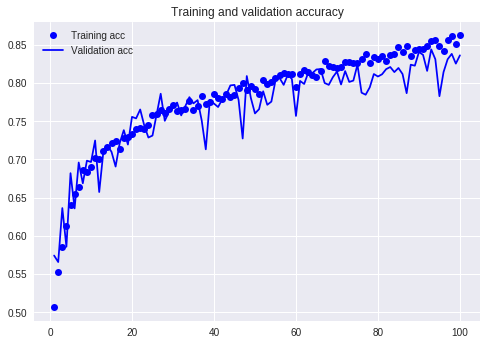

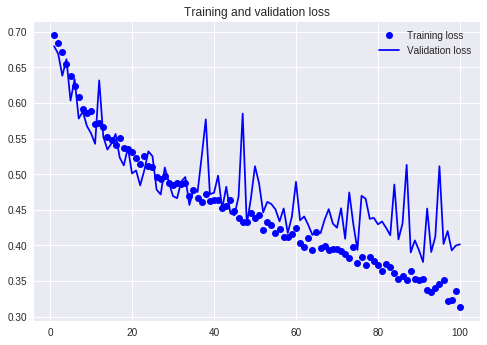

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)

plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Transfer learning  

Use a pretrained model VGG16 as a foundation to build our network

In [0]:
conv_base = VGG16(weights='imagenet',include_top=False,input_shape=(150,150,3))
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

Two ways to use the pretrained network -


1.   Run the Conv base on the dataset and store output in numpy array. Then train a Dense classifier on it.
2.   Extend the Conv base by adding Dense layers to it and run the whole network end to end




Let’s set up the first
one: recording the output of conv_base on your data and using these outputs as
inputs to a new model.

In [0]:
base_dir = '/content/gdrive/My Drive/Colab Notebooks/data/dogs-vs-cats_small'
train_dir = os.path.join(base_dir,'train')
test_dir = os.path.join(base_dir,'test')
validation_dir = os.path.join(base_dir,'validation')

datagen = ImageDataGenerator(rescale=1./255)
batch_size=20

def extract_features(directory, sample_count):
  features = np.zeros(shape=(sample_count, 4, 4, 512))
  labels = np.zeros(shape=(sample_count))
  generator = datagen.flow_from_directory(directory, target_size=(150,150),
                                         batch_size=batch_size,
                                         class_mode='binary')
  i=0
  for inputs_batch, labels_batch in generator:
    features_batch = conv_base.predict(inputs_batch)
    features[i*batch_size : (i+1)*batch_size] = features_batch
    labels[i*batch_size : (i+1)*batch_size] = labels_batch
    i += 1
    
    if i*batch_size>=sample_count:
      break
  return features,labels

In [0]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Reshape features from (samples, 4, 4 ,512) to (samples,4 x 4 x 512) to feed to Dense layer

In [0]:
train_features = np.reshape(train_features,(2000,4*4*512))
validation_features = np.reshape(validation_features, (1000,4*4*512))
test_features = np.reshape(test_features, (1000,4*4*512))

Define your densely connected classifier  and train it on the data and labels that you just recorded. Training is very fast, because you only have to deal with two Dense layers—an epoch takes less than one second even on CPU.

In [0]:
model = models.Sequential()
model.add(layers.Dense(256,activation='relu',input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['acc'])

history = model.fit(train_features, train_labels, epochs=30, batch_size=20, validation_data=(validation_features, validation_labels))
model.save('./gdrive/My Drive/Colab Notebooks/models/cats_and_dogs_VGG16_type1.h5')

Instructions for updating:
Use tf.cast instead.
Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 2s 888us/step - loss: 0.4620 - acc: 0.7795 - val_loss: 0.3026 - val_acc: 0.8930
Epoch 2/30
2000/2000 [==============================] - 1s 380us/step - loss: 0.2933 - acc: 0.8740 - val_loss: 0.2592 - val_acc: 0.9010
Epoch 3/30
2000/2000 [==============================] - 1s 393us/step - loss: 0.2402 - acc: 0.8970 - val_loss: 0.2768 - val_acc: 0.8830
Epoch 4/30
2000/2000 [==============================] - 1s 383us/step - loss: 0.2054 - acc: 0.9125 - val_loss: 0.2405 - val_acc: 0.9030
Epoch 5/30
2000/2000 [==============================] - 1s 380us/step - loss: 0.1783 - acc: 0.9285 - val_loss: 0.2633 - val_acc: 0.8910
Epoch 6/30
2000/2000 [==============================] - 1s 387us/step - loss: 0.1621 - acc: 0.9405 - val_loss: 0.2413 - val_acc: 0.9020
Epoch 7/30
2000/2000 [==============================] - 1s 391us/step - loss: 0.1427 - a

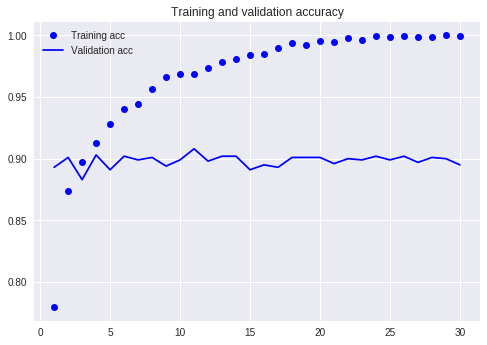

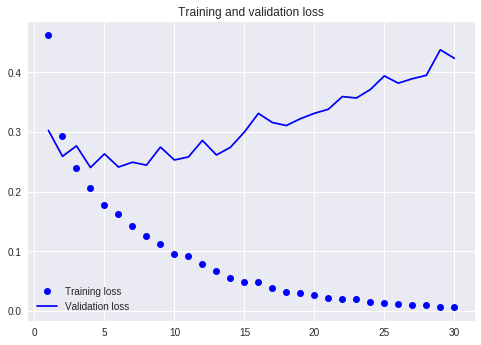

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

The plots also indicate that you’re overfitting almost from the start—despite using dropout with a fairly large rate. That’s because this technique doesn’t use data augmentation, which is essential for preventing overfitting with small image datasets.

Let’s review the second technique which includes data augmentation during training.  In this we extend the conv_base model and run it end to end on the inputs. 

We need to freeze the conv_base network so that its weights are not updated during training the dense layers that we added

In [0]:
conv_base.trainable = False

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


Now we start training the model, with the same data-augmentation configuration we used earlier. 

Note - validation data shouldnt be augmented


In [0]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(dir+'/train', 
                                                    target_size=(150,150), 
                                                    batch_size=20,
                                                    class_mode='binary') #because we use binary_crossentropy loss

validation_generator = test_datagen.flow_from_directory(dir+'/validation', 
                                                        target_size=(150,150), 
                                                        batch_size=20,
                                                        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(train_generator,
                             steps_per_epoch=100,
                             epochs=30,
                             validation_data=validation_generator,
                             validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 33s 328ms/step - loss: 0.0538 - acc: 0.9860 - val_loss: 0.2924 - val_acc: 0.9400
Epoch 2/30
100/100 [==============================] - 30s 298ms/step - loss: 0.0307 - acc: 0.9900 - val_loss: 0.3212 - val_acc: 0.9280
Epoch 3/30
100/100 [==============================] - 30s 299ms/step - loss: 0.0489 - acc: 0.9850 - val_loss: 0.5971 - val_acc: 0.8960
Epoch 4/30
100/100 [==============================] - 30s 298ms/step - loss: 0.0453 - acc: 0.9885 - val_loss: 0.3565 - val_acc: 0.9320
Epoch 5/30
100/100 [==============================] - 30s 299ms/step - loss: 0.0389 - acc: 0.9895 - val_loss: 1.2099 - val_acc: 0.8440
Epoch 6/30
100/100 [==============================] - 30s 298ms/step - loss: 0.0284 - acc: 0.9900 - val_loss: 0.3141 - val_acc: 0.9300
Epoch 7/30
100/100 [==============================] - 30s 300ms/step - loss: 0.0339 - acc: 0.9895 - val_lo

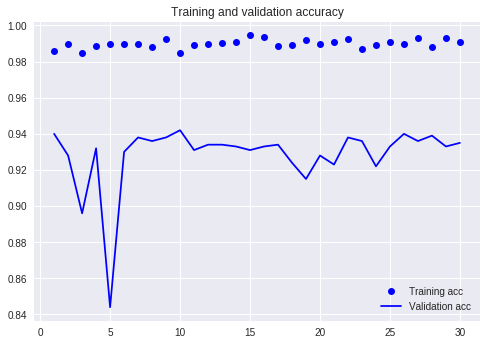

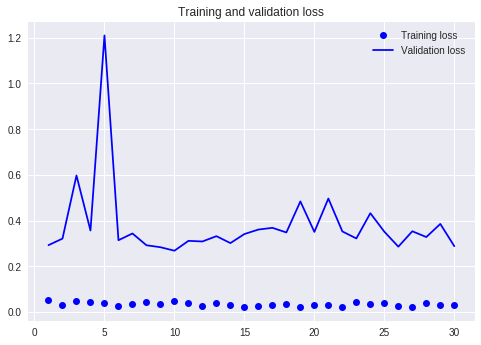

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

To perform further fine tuning we can unfreeze some of the layers in the conv_base and retrain them with the layers we added. This should only be done after we have finished training the network we added.

In [0]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

Freezing all layers up to a specific one. We will fine tune layers block5_conv1, block5_conv2, and block5_conv3

In [0]:
conv_base.trainable = True
set_trainable = False

for layer in conv_base.layers:
  if layer.name=='block5_conv1':
    set_trainable = True
    
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

Now fine tune using a small learning rate to limit the magnitude of modifications we make to the 3 layers.

In [0]:
model.compile(optimizer=optimizers.RMSprop(lr=1e-5),loss='binary_crossentropy',metrics=['acc'])

history = model.fit_generator(train_generator, steps_per_epoch=100, 
                              epochs=100, validation_data=validation_generator, 
                              validation_steps=50)

model.save('./gdrive/My Drive/Colab Notebooks/models/cats_and_dogs_VGG16_type2_finetuned.h5')

Epoch 1/30
100/100 [==============================] - 33s 334ms/step - loss: 0.0077 - acc: 0.9970 - val_loss: 0.3464 - val_acc: 0.9460
Epoch 2/30
100/100 [==============================] - 30s 298ms/step - loss: 0.0176 - acc: 0.9940 - val_loss: 0.3423 - val_acc: 0.9450
Epoch 3/30
100/100 [==============================] - 30s 298ms/step - loss: 0.0164 - acc: 0.9965 - val_loss: 0.7145 - val_acc: 0.9020
Epoch 4/30
100/100 [==============================] - 30s 297ms/step - loss: 0.0112 - acc: 0.9965 - val_loss: 0.3987 - val_acc: 0.9340
Epoch 5/30
100/100 [==============================] - 30s 302ms/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.3717 - val_acc: 0.9420
Epoch 6/30
100/100 [==============================] - 30s 300ms/step - loss: 0.0110 - acc: 0.9945 - val_loss: 0.3743 - val_acc: 0.9410
Epoch 7/30
100/100 [==============================] - 30s 298ms/step - loss: 0.0057 - acc: 0.9975 - val_loss: 0.3464 - val_acc: 0.9460
Epoch 8/30
100/100 [==============================] - 3

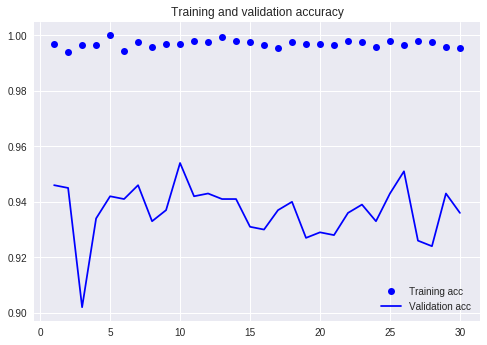

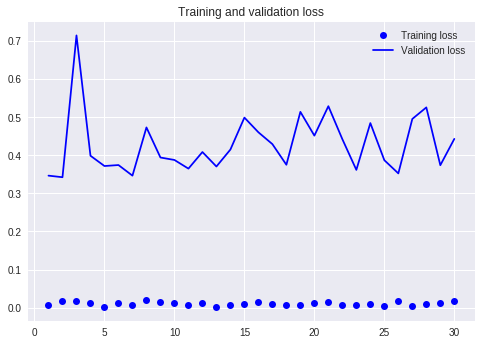

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Smoothing the plots

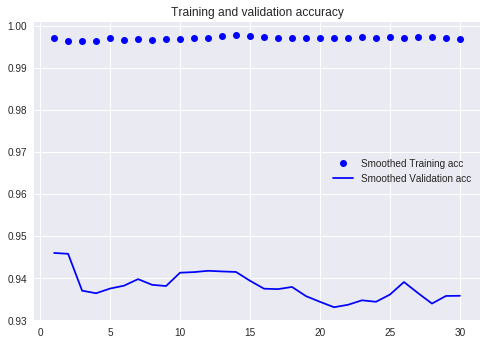

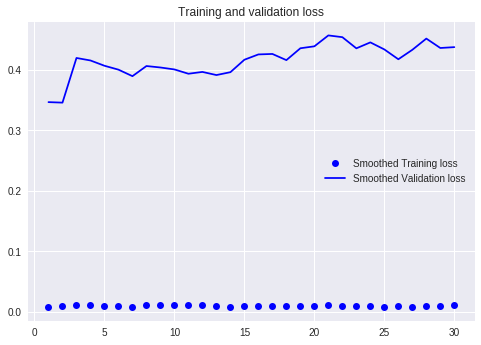

In [0]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1-factor))
    else:
      smoothed_points.append(point)
  return smoothed_points


plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed Training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed Training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Finally evaluate the model on test data

In [0]:
test_generator = test_datagen.flow_from_directory(dir+'/test',
                                                  target_size=(150, 150),
                                                  batch_size=20,
                                                  class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
test acc: 0.9459999930858612


### Visualizing ConvNets

Let's visualize to see what Convnets learn. There are 3 different ways

1.  Visualizing intermediate convnet outputs
2.  Visualizing convnets filters
3.  Visualizing heatmaps of class activation in an image



In [0]:
model = models.load_model('./gdrive/My Drive/Colab Notebooks/models/cats_and_dogs_small_2.h5')
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 34, 34, 128)       73856     
_______________________________________

#### Visualizing intermediate activations using the above network

(1, 150, 150, 3)


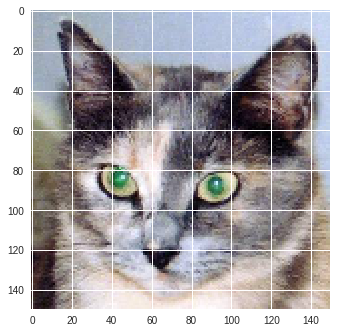

In [0]:
dir = '/content/gdrive/My Drive/Colab Notebooks/data/dogs-vs-cats_small'
img_path = dir+"/test/cats/cat.1700.jpg"

img = image.load_img(img_path,target_size=(150,150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor,axis=0)
img_tensor /= 255.
print(img_tensor.shape)
plt.imshow(img_tensor[0])
plt.show()

In [0]:
layer_outputs = [layer.output for layer in model.layers[:8]] #extract output of the top eight layers
activation_model = models.Model(inputs=model.input, outputs=layer_outputs) #create a model to return the outputs, given the model input
activations = activation_model.predict(img_tensor) #returns list of 5 numpy arrays, one per activation layer

Let’s try plotting the fourth channel of
the activation of the first layer of the original model

(1, 148, 148, 32)


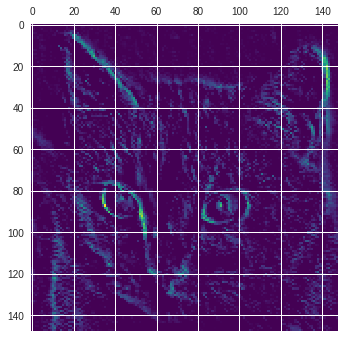

In [0]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

plt.matshow(first_layer_activation[0, :, :,7], cmap ='viridis')

let’s plot a complete visualization of all the activations in the network . You’ll extract and plot every channel in each of the eight activation maps,
and you’ll stack the results in one big image tensor, with channels stacked side by side.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


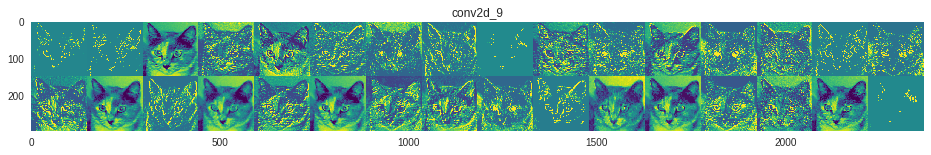

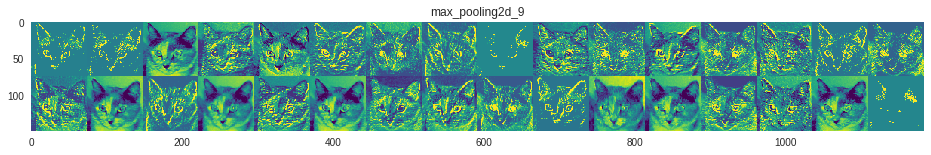

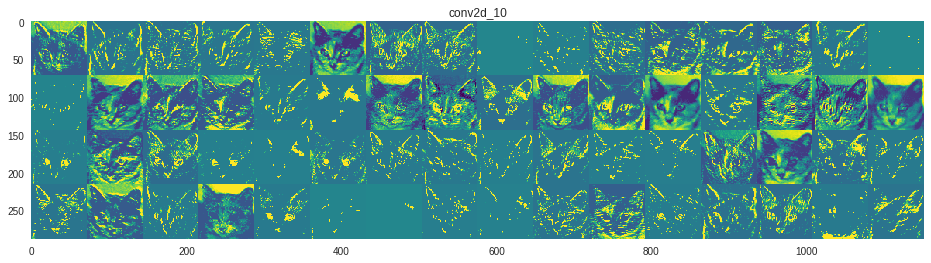

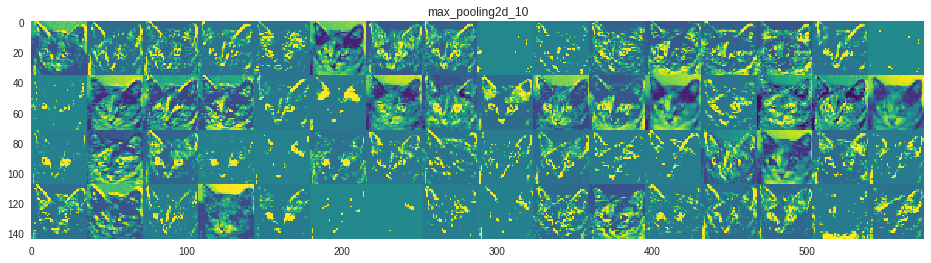

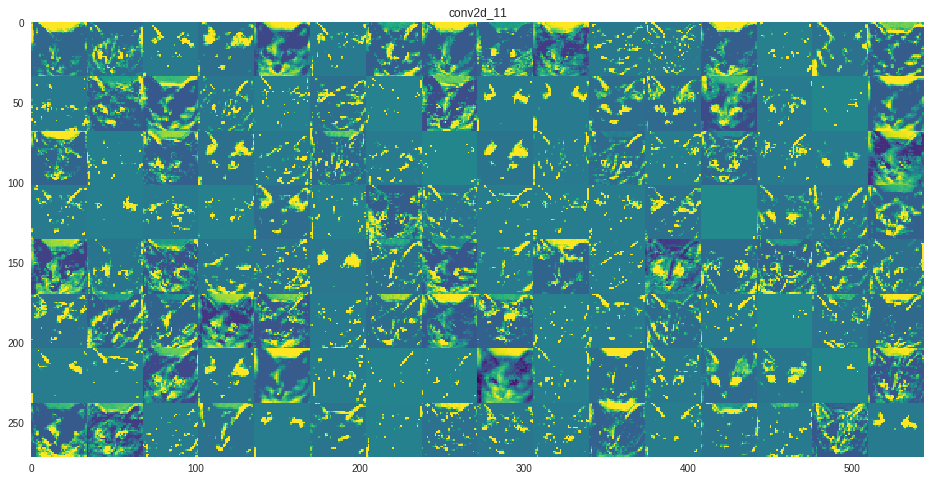

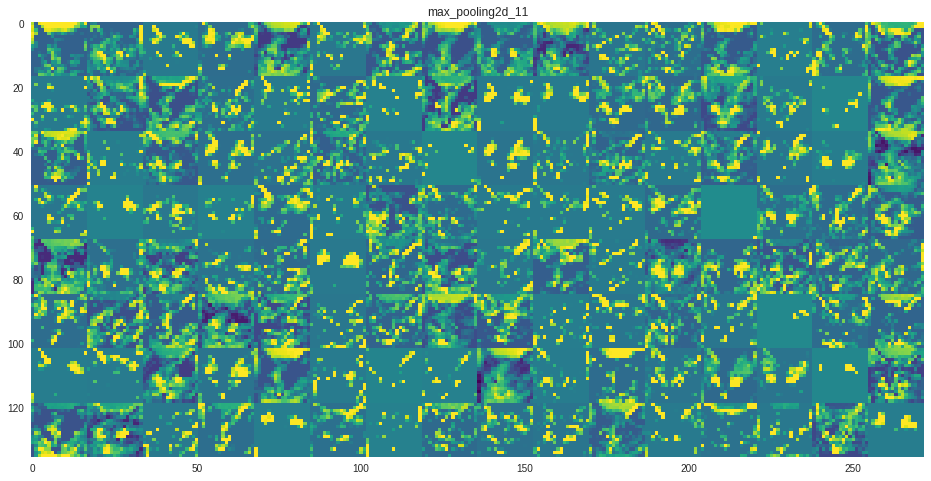

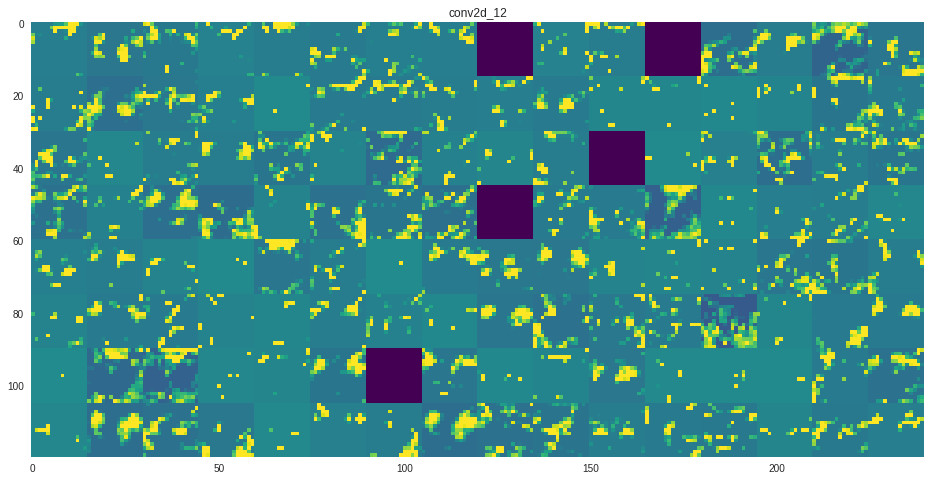

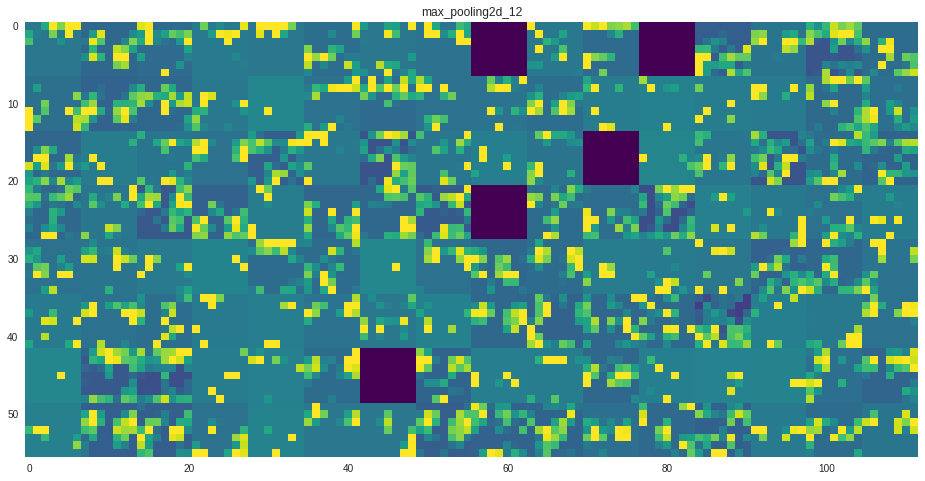

In [0]:
layer_names = []
for layer in model.layers[:8]:
  layer_names.append(layer.name)
  
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
  n_features = layer_activation.shape[-1]        #number of features in the feature map
  size = layer_activation.shape[1]               #feature map has shape (l,size,size,n_features)
  
  n_cols = n_features//images_per_row            #tiles the activation channels in this matrix
  display_grid = np.zeros((size*n_cols, images_per_row*size))
  
   # We'll tile each filter into this big horizontal grid
  for col in range(n_cols):
    for row in range(images_per_row):
      channel_image = layer_activation[0,:,:,col*images_per_row + row]
      
      #Post process the feature to make it visually palatable
      channel_image -= channel_image.mean()
      channel_image /= channel_image.std()
      channel_image *= 64
      channel_image += 128
      channel_image = np.clip(channel_image,0,255).astype('uint8')
      
      display_grid[col*size : (col+1)*size, 
                   row*size : (row+1)*size] = channel_image
  
  #Display the grid
  scale = 1./size
  plt.figure(figsize=(scale*display_grid.shape[1],
                     scale*display_grid.shape[0]))
  plt.title(layer_name)
  plt.grid(False)
  plt.imshow(display_grid, aspect='auto', cmap = 'viridis')

There are a few things to note here:
1. first layer acts as a collection of various edge detectors. At that stage, the
activations retain almost all of the information present in the initial picture.
2. As you go higher, the activations become increasingly abstract and less visually
interpretable. They begin to encode higher-level concepts such as “cat ear” and
“cat eye.” Higher presentations carry increasingly less information about the
visual contents of the image, and increasingly more information related to the
class of the image.
3. The sparsity of the activations increases with the depth of the layer: in the first
layer, all filters are activated by the input image; but in the following layers,
more and more filters are blank. This means the pattern encoded by the filter
isn’t found in the input image.

#### Visualizing Convnet filters by gradient ascent

In [0]:
def generate_pattern(layer_name,filter_index,size=150):

    #build a loss function that maximizes the activation of the nth filter of the layer under consideration
    layer_output = model.get_layer(layer_name).output
    loss = tf.mean(layer_output[:, :, :,filter_index])
    
    #obtain the gradient of the input picture with regards to this loss
    grads = tf.gradients(loss,model.input)[0] #Returns a list of tensors of size 1 in this case so keep only the first element
    
    #normalize gradients using L2 norm
    grads /= (tf.sqrt(tf.mean(tf.square(grads)))+1e-5)

    #compute value of loss and gradient given an input
    iterate = tf.function([model.input],[loss,grads])
    
    input_img_data = np.random.random((1,size,size,3))*20 + 128.  #start with a gray image with some noise
    
    step = 1. #magnitude of each gradient update
    for i in range(40):  #run Gradient ascent for 40 steps
      loss_value, grads_value = iterate([input_img_data])   #comupute the loss & gradient value
      input_img_data += grads_value*step   #adjust the input image in the direction that maximizes the loss
      
    img = input_img_data[0]
    return deprocess_image(img)

Post process the resulting image tensor to turn it into a displayable image

In [0]:
def deprocess_image(x):
  #normalize the tensor : center on 0 & std = 0.1
  x -= x.mean()
  x /= (x.std()+1e-5)
  x *= 0.1
  
  #clip to [0,1]
  x += 0.5
  x = np.clip(x, 0, 1)
  
  #convert to RGB array
  x *= 255
  x = np.clip(x,0,255).astype('uint8')
  return x

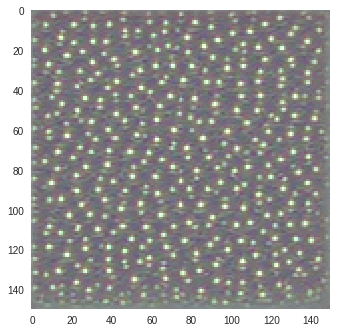

In [0]:
model = VGG16(weights='imagenet',include_top=False)
plt.grid(False)
plt.imshow(generate_pattern('block3_conv1',0))

Use the above function to generate a grid of all filter response patterns in a layer

In [0]:
for layer_name in ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1']:
  size, margin = 64, 5

  results = np.zeros((8*size+7*margin, 8*size+7*margin, 3)) #Empty (black) image to store results

  for i in range(8):  #iterate over rows of the result grid
    for j in range(8): #iterate over columns of the result grid
      
      #Generate pattern for filter i+(j*8) in layer_name
      filter_img = generate_pattern(layer_name, i+(j*8), size=size) 

      #put result in the square (i,j) of the results grid
      horizontal_start = i*size + i*margin
      horizontal_end = horizontal_start + size
      vertical_start = j*size + j*margin
      vertical_end = vertical_start + size
      results[horizontal_start:horizontal_end, vertical_start:vertical_end, :] = filter_img
    
  #Displays the results grid     
  plt.figure(figsize=(17,17))
  plt.imshow(results.astype('uint8'))

Output hidden; open in https://colab.research.google.com to view.

#### Visualizing heatmaps of class activation

In [0]:
model = VGG16(weights='imagenet')
img_path= '/content/gdrive/My Drive/Colab Notebooks/data/cc_elephant.jpg'

img = image.load_img(img_path, target_size=(224,224))
x = image.img_to_array(img)  #float32 numpy array of shape (224,224,3)
x = np.expand_dims(x,axis=0) #add a dimension to transform the array into a batch of size (1,224,224,3)
x = preprocess_input(x)      #preprocess the batch (channel-wise color normalization)

Run the pretrained network on the image and decode its prediction vector
back to a human-readable format:

In [0]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])
np.argmax(preds[0])

Predicted: [('n02504458', 'African_elephant', 0.9094216), ('n01871265', 'tusker', 0.086182274), ('n02504013', 'Indian_elephant', 0.0043545775)]


386

Set up the Grad-CAM algorithm

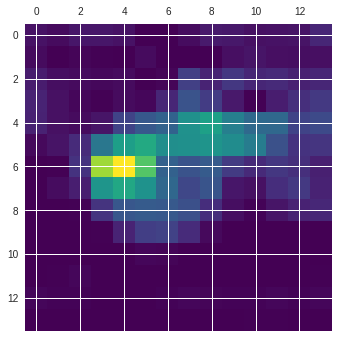

In [0]:
african_elephant_output = model.output[:,386]
last_conv_layer = model.get_layer('block5_conv3')

grads = tf.gradients(african_elephant_output,last_conv_layer.output)[0]
pooled_grads = tf.mean(grads, axis=(0,1,2))

#access the values of the quantities we defined : pooled_grads & the output feature map of block5_conv3, given a sample image
iterate = tf.function([model.input], [pooled_grads, last_conv_layer.output[0]])

#values of these two quantities  as numpy arrays, given the sample image
pooled_grads_value, conv_layer_output_value = iterate([x])

#multiplies each channel in the feature-map array by how important this channel is for "elephant" class
for i in range(512):
  conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  
heatmap = np.mean(conv_layer_output_value, axis=-1) #channel-wise mean of the resulting feature map is the heatmap of class activation

#normalize the heatmap between 0-1
heatmap = np.maximum(heatmap,0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap,cmap='viridis')
plt.show()

use OpenCV to generate an image that superimposes the original image on the heatmap you just obtained

In [0]:
import cv2

img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap,(img.shape[1],img.shape[0])) #resize the heatmap to be the same size as the original image

heatmap = np.uint8(255*heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET) #applies the heatmap to the original image

superimposed_img = heatmap*0.4 + img  #0.4 is heatmap intensity factor
cv2.imwrite('/content/gdrive/My Drive/Colab Notebooks/data/elephant_cam.jpg',superimposed_img)